2023/12
## skku DataMining project : 
## 서울 대중교통 혼잡도 및 중심성 그래프분석(Seoul_transportation_GraphMining)
contributer : 김민, 김효원, 이수정, 조병웅  
instruction :   
블로거 GD park manger님의 대중교통 분석 연구를 바탕으로, 서울시 대중교통 네트워크의 중심성을 살펴보고,
사용목적 대비 유동인구 수라는 혼잡도 개념을 추가하여 새로 발전된 인사이트를 제공함을 목적으로 함.
참고한 분석 연구의 주소 -> https://m.blog.naver.com/gdpresent/221147909255

## graph_bus 파일
서울시 열린데이터 광장에서 얻은 서울시버스노선정보를 바탕으로 버스정류장과 버스 노선을 노드화 및 엣지화

# 라이브러리 및 데이터 로딩
데이터 출처: https://data.seoul.go.kr/dataList/OA-1095/L/1/datasetView.do

In [ ]:
# 한글 폰트 설치 후 런타임 다시 시작
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

from IPython.display import clear_output
clear_output()

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
data = pd.read_excel('../데이터/로데이터/서울시버스노선별정류소정보(20230914).xlsx')
df = data[['노선명', '순번', 'ARS_ID', '정류소명', 'X좌표', 'Y좌표']]

print(df.shape)
df.head()

(46688, 6)


,노선명,순번,ARS_ID,정류소명,X좌표,Y좌표
0,6500,1,22770,더케이호텔정문,127.032868,37.466426
1,2312A,1,25341,강동공영차고지,127.174627,37.564251
2,342,1,25341,강동공영차고지,127.174627,37.564251
3,3323,1,25341,강동공영차고지,127.174627,37.564251
4,강동05,1,25341,강동공영차고지,127.174627,37.564251


## 데이터 전처리
- 타깃이 되는 간선버스 노선만 추출
- 가상 정류소 제거(이상치 제거)
- 정류소명 정리
- 역 노드, 버스 정류장 노드 분리
- 중복 제거
- 지하철 환승 가능 버스 정류소에 지하철역 ARS ID 부여
- ARS ID로 구성된 엣지 생성
- 지하철 환승 가능 정류소 title 변경
- 지하철역 통합으로 인한 오류 노선 제거

In [ ]:
# 간선버스 노선 추출 (노선번호 3자리 숫자)
df = df[df['노선명'].str.match(r'^\d{3}$|^\d{3}[A-Z]{1}$')]
df = df.sort_values(by=['노선명', '순번']).reset_index(drop=True) # 노선명, 순번 정렬

In [ ]:
# 가상 정류소(정차X) 제거
print('가상 정류소 제거 전:', len(df))
fake = df[df['정류소명'].str.contains('가상')]
df.drop(fake.index, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)
print('가상 정류소 제거 후:', len(df))

가상 정류소 제거 전: 13918
가상 정류소 제거 후: 13874


In [ ]:
# 괄호 내용 제거 함수
def delWord(station):
    if ('(' in station) and (')' in station):
        idx1 = station.index('(')
        idx2 = station.index(')')
        return station[:idx1] + station[idx2+1:]
    return station

# 정류소명 내 괄호 내용 제거
df['정류소명'] = df['정류소명'].map(delWord)

In [ ]:
idList, nameList = list(df.ARS_ID), list(df.정류소명)
title = ['%d_%s'%(idList[i], nameList[i]) for i in range(len(df))]
df['title'] = title
df

,노선명,순번,ARS_ID,정류소명,X좌표,Y좌표,title
0,100,1,11428,한성여객종점,127.070056,37.638130,11428_한성여객종점
1,100,2,11387,노원평생학습관,127.068935,37.639343,11387_노원평생학습관
2,100,3,11374,서울시립북서울미술관,127.066741,37.639748,11374_서울시립북서울미술관
3,100,4,11373,중계역,127.065089,37.643220,11373_중계역
4,100,5,11376,중계역2번출구,127.064939,37.645618,11376_중계역2번출구
...,...,...,...,...,...,...,...
13869,775,82,63242,파주시청,126.778390,37.758796,63242_파주시청
13870,775,83,63233,장안아파트,126.777311,37.760457,63233_장안아파트
13871,775,84,63201,금촌사거리,126.775657,37.762809,63201_금촌사거리
13872,775,85,63213,장안미래아파트,126.776455,37.764548,63213_장안미래아파트


In [ ]:
# '역' 포함 버스 정류소 추출
condition = df['정류소명'].str.contains('역') & ~df['정류소명'].str.contains('역사문화|역사박물관|역사재단|한국지역|기차역')
df_trans = df[condition]
df_trans

,노선명,순번,ARS_ID,정류소명,X좌표,Y좌표,title
3,100,4,11373,중계역,127.065089,37.643220,11373_중계역
4,100,5,11376,중계역2번출구,127.064939,37.645618,11376_중계역2번출구
11,100,12,11426,하계역,127.069488,37.636854,11426_하계역
39,100,41,2004,서울역버스환승센터,126.972595,37.555389,2004_서울역버스환승센터
41,100,43,3010,숙대입구역,126.972232,37.543756,3010_숙대입구역
...,...,...,...,...,...,...,...
13783,774,156,12017,연신내역.연서시장,126.921840,37.618360,12017_연신내역.연서시장
13786,774,159,12011,구파발역입구,126.917023,37.636164,12011_구파발역입구
13827,775,40,35105,삼송역사거리.지축차량기지입구,126.897602,37.654782,35105_삼송역사거리.지축차량기지입구
13831,775,44,12113,구파발역.롯데몰,126.918533,37.637246,12113_구파발역.롯데몰


In [ ]:
 # 중복 제거
print(len(df_trans))
df_trans = df_trans.drop_duplicates(subset=['title'])
print(len(df_trans))
df_trans

3133
891


,노선명,순번,ARS_ID,정류소명,X좌표,Y좌표,title
3,100,4,11373,중계역,127.065089,37.643220,11373_중계역
4,100,5,11376,중계역2번출구,127.064939,37.645618,11376_중계역2번출구
11,100,12,11426,하계역,127.069488,37.636854,11426_하계역
39,100,41,2004,서울역버스환승센터,126.972595,37.555389,2004_서울역버스환승센터
41,100,43,3010,숙대입구역,126.972232,37.543756,3010_숙대입구역
...,...,...,...,...,...,...,...
13471,771,82,35005,원릉역,126.839358,37.662945,35005_원릉역
13489,771,100,36551,일산역,126.769907,37.681431,36551_일산역
13636,774,9,12122,불광역4번출구,126.930336,37.609758,12122_불광역4번출구
13647,774,20,19706,삼송역현대헤리엇아파트,126.898416,37.652876,19706_삼송역현대헤리엇아파트


In [ ]:
# 버스 정류소별 ARS ID
busDict = df_trans.set_index('정류소명').to_dict()['ARS_ID']
print('버스:', busDict)

# 지하철 ARS ID
subway = pd.read_csv('./node_subway.csv', encoding='cp949')
subDict = subway.set_index('name').to_dict()['ARS_ID']
print('지하철:', subDict)

버스: {'중계역': 11366, '중계역2번출구': 11376, '하계역': 11416, '서울역버스환승센터': 2005, '숙대입구역': 3229, '삼각지역': 3007, '신용산역': 3003, '이촌동한강맨션.이촌역': 3218, '서빙고역1번출구': 3325, '서빙고역교차로': 3267, '이촌동한가람아파트.이촌역': 3217, '서울역버스환승센터.강우규의거터': 2007, '혜화역.마로니에공원': 1220, '혜화역.동성중고': 1229, '우이동도선사입구.북한산우이역': 9102, '쌍문역': 10016, '수유역': 9003, '미아역.신일중고': 9008, '미아사거리역': 9012, '동대문역.흥인지문': 1023, '신설동역1번출구': 6107, '수유역.강북구청': 9004, '쌍문역.쌍리단길': 10126, '노원역9번출구': 11210, '중계역1번출구': 11390, '노원역1번출구': 11211, '보문역': 8295, '가오리역': 9123, '충무로역8번출구.대한극장앞': 2154, '퇴계로2가.명동역5번출구': 2150, '남대문시장.회현역': 2146, '명동역4번출구': 2149, '충무로역2번출구.대한극장앞': 2153, '공릉역4번출구': 11162, '태릉입구역3번출구': 11104, '묵동삼거리.먹골역': 7103, '먹골역': 7426, '지하철7호선중화역': 7108, '중랑역.동부시장': 7006, '청량리역환승센타': 6016, '제기동역.서울약령시': 6023, '신설동역': 6102, '청량리역환승센터': 6019, '먹골역.묵동자이아파트': 7104, '태릉입구역4번출구': 11103, '공릉역1번출구': 11161, '가능역.성베드로병원': 61001, '의정부역.흥선지하도입구': 61010, '의정부역센트럴자이.위브캐슬아 ': 61024, '회룡역': 61029, '망월사역3번출구': 61020, '도봉산역': 10002, '서울북부지방법원.검찰청.도봉역성황당': 10006, '신도봉시장.도봉구청

In [ ]:
# 지하철 환승 가능 버스 정류소에 지하철역 ARS ID 부여하는 함수
def getID(x):
    if '연신내역' in x: # 신내역/연신내역 구분
        return subDict['연신내역']
    for sub in subway.name:
        if sub in x:
            return subDict[sub]
    return busDict[x]

In [ ]:
df_trans['newID'] = df_trans['정류소명'].map(getID)
trans = df_trans[df_trans['newID'] < 1000] # 지하철 환승 가능 정류소
trans

,노선명,순번,ARS_ID,정류소명,X좌표,Y좌표,title,newID
3,100,4,11373,중계역,127.065089,37.643220,11373_중계역,308
4,100,5,11376,중계역2번출구,127.064939,37.645618,11376_중계역2번출구,308
11,100,12,11426,하계역,127.069488,37.636854,11426_하계역,333
39,100,41,2004,서울역버스환승센터,126.972595,37.555389,2004_서울역버스환승센터,181
41,100,43,3010,숙대입구역,126.972232,37.543756,3010_숙대입구역,206
...,...,...,...,...,...,...,...,...
13306,760,97,36699,주엽역,126.761653,37.670023,36699_주엽역,307
13309,760,100,36281,대화역,126.747512,37.676358,36281_대화역,87
13636,774,9,12122,불광역4번출구,126.930336,37.609758,12122_불광역4번출구,154
13647,774,20,19706,삼송역현대헤리엇아파트,126.898416,37.652876,19706_삼송역현대헤리엇아파트,163


In [ ]:
#병합코드
titleDF = pd.merge(left=trans, right=subway, left_on='newID', right_on='ARS_ID', how='left')
titleDF = titleDF[['title_x', 'title_y']]
titleDF

,title_x,title_y
0,11373_중계역,308_중계역
1,11376_중계역2번출구,308_중계역
2,11426_하계역,333_하계역
3,2004_서울역버스환승센터,181_서울역
4,3010_숙대입구역,206_숙대입구역
...,...,...
826,36699_주엽역,307_주엽역
827,36281_대화역,87_대화역
828,12122_불광역4번출구,154_불광역
829,19706_삼송역현대헤리엇아파트,163_삼송역


In [ ]:
#확인코드
lanes = df['노선명'].unique()
print('버스 종류:', len(lanes))
lanes

버스 종류: 136


array(['100', '101', '102', '103', '104', '105', '106', '107', '108',
       '109', '111', '120', '121', '130', '140', '141', '142', '143',
       '144', '145', '146', '147', '148', '150', '151', '152', '160',
       '162', '163', '171', '172', '173', '201', '202', '240', '241',
       '242', '260', '261', '262', '270', '271', '271B', '272', '273',
       '301', '302', '303', '320', '333', '340', '341', '342', '343',
       '345', '350', '351', '352', '360', '361', '370', '400', '401',
       '402', '405', '406', '407', '420', '421', '440', '441', '452',
       '461', '462', '463', '470', '471', '472', '500', '501', '502',
       '503', '504', '505', '506', '507', '540', '541', '542', '571',
       '600', '601', '602', '603', '604', '605', '606', '640', '641',
       '642', '643', '650', '651', '652', '653', '654', '660', '661',
       '662', '670', '672', '673', '674', '700', '701', '703', '704',
       '705', '706', '708', '710', '720', '721', '740', '741', '742',
       '750A', '750

In [ ]:
num, source, target = [], [], []

for lane in tqdm(lanes):
    bus = list(df[df['노선명']==lane].title)
    num += [lane for _ in range(len(bus)-1)]
    source += bus[:-1]
    target += bus[1:]

# ARS ID로 구성된 엣지 생성
edge = pd.DataFrame({'LaneNo': num, 'source': source, 'target': target})
edge

  0%|          | 0/136 [00:00<?, ?it/s]

,LaneNo,source,target
0,100,11428_한성여객종점,11387_노원평생학습관
1,100,11387_노원평생학습관,11374_서울시립북서울미술관
2,100,11374_서울시립북서울미술관,11373_중계역
3,100,11373_중계역,11376_중계역2번출구
4,100,11376_중계역2번출구,11378_중계3단지목련아파트
...,...,...,...
13733,775,63240_교육지원청,63242_파주시청
13734,775,63242_파주시청,63233_장안아파트
13735,775,63233_장안아파트,63201_금촌사거리
13736,775,63201_금촌사거리,63213_장안미래아파트


In [ ]:
# 지하철 환승 가능 정류소 title 변경
for i in tqdm(range(len(titleDF))):
    new = titleDF.iloc[i]
    edge = edge.replace(new['title_x'], new['title_y'])

  0%|          | 0/831 [00:00<?, ?it/s]

In [ ]:
# 지하철역 통합으로 인한 오류 노선 제거
edge = edge[edge['source'] != edge['target']]
edge.reset_index(drop=True, inplace=True)
edge

,LaneNo,source,target
0,100,11428_한성여객종점,11387_노원평생학습관
1,100,11387_노원평생학습관,11374_서울시립북서울미술관
2,100,11374_서울시립북서울미술관,308_중계역
3,100,308_중계역,11378_중계3단지목련아파트
4,100,11378_중계3단지목련아파트,11380_목련아파트상가
...,...,...,...
13400,775,63240_교육지원청,63242_파주시청
13401,775,63242_파주시청,63233_장안아파트
13402,775,63233_장안아파트,63201_금촌사거리
13403,775,63201_금촌사거리,63213_장안미래아파트


In [ ]:
print(len(df))
node = df.drop_duplicates(subset=['title'])[['title', 'ARS_ID', '정류소명', 'X좌표', 'Y좌표']]
node.columns = ['title', 'ARS_ID', 'name', 'X', 'Y']
print(len(node))
node

13874
5455


,title,ARS_ID,name,X,Y
0,11428_한성여객종점,11428,한성여객종점,127.070056,37.638130
1,11387_노원평생학습관,11387,노원평생학습관,127.068935,37.639343
2,11374_서울시립북서울미술관,11374,서울시립북서울미술관,127.066741,37.639748
3,11373_중계역,11373,중계역,127.065089,37.643220
4,11376_중계역2번출구,11376,중계역2번출구,127.064939,37.645618
...,...,...,...,...,...
13869,63242_파주시청,63242,파주시청,126.778390,37.758796
13870,63233_장안아파트,63233,장안아파트,126.777311,37.760457
13871,63201_금촌사거리,63201,금촌사거리,126.775657,37.762809
13872,63213_장안미래아파트,63213,장안미래아파트,126.776455,37.764548


In [ ]:
for i in tqdm(range(len(titleDF))):
    new = titleDF.iloc[i]
    node = node.replace(new['title_x'], new['title_y'])

node
# 버스 정류소 노드와 지하철역 노드 병합 후 title 기준 중복 제거 처리

  0%|          | 0/831 [00:00<?, ?it/s]

,title,ARS_ID,name,X,Y
0,11428_한성여객종점,11428,한성여객종점,127.070056,37.638130
1,11387_노원평생학습관,11387,노원평생학습관,127.068935,37.639343
2,11374_서울시립북서울미술관,11374,서울시립북서울미술관,127.066741,37.639748
3,308_중계역,11373,중계역,127.065089,37.643220
4,308_중계역,11376,중계역2번출구,127.064939,37.645618
...,...,...,...,...,...
13869,63242_파주시청,63242,파주시청,126.778390,37.758796
13870,63233_장안아파트,63233,장안아파트,126.777311,37.760457
13871,63201_금촌사거리,63201,금촌사거리,126.775657,37.762809
13872,63213_장안미래아파트,63213,장안미래아파트,126.776455,37.764548


In [ ]:
node['title'] = node['title'].str.replace(' ', '')
node['name'] = node['name'].str.replace(' ', '')
edge['source'] = edge['source'].str.replace(' ', '')
edge['target'] = edge['target'].str.replace(' ', '')

## 파일로 저장

In [ ]:
# 파일 저장
node.to_csv('./node_bus.csv', index=None, encoding='cp949')
edge.to_csv('./edge_bus.csv', index=None, encoding='cp949')

In [ ]:
graph = nx.DiGraph()
graph.add_nodes_from(node.set_index('title').T.to_dict().items())
graph.add_edges_from(edge[['source', 'target']].values.tolist())
print(graph.number_of_nodes(), graph.number_of_edges())

4884 6392


## 그래프 시각화

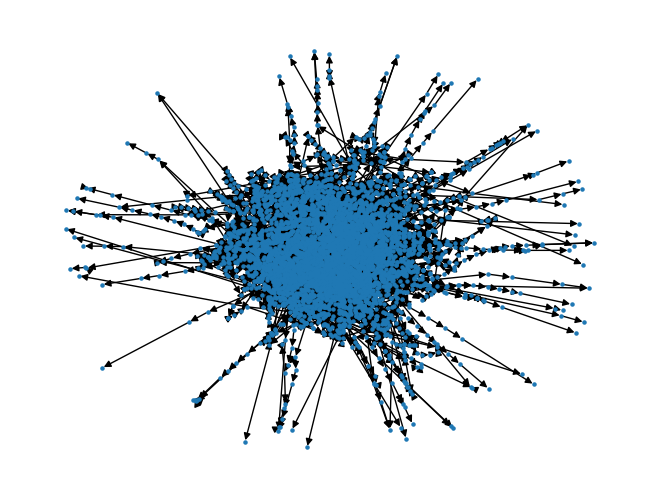

In [ ]:
pos = nx.spring_layout(graph, seed=42)

nx.draw(graph, pos, node_size=5)

plt.axis('off')
plt.tight_layout()

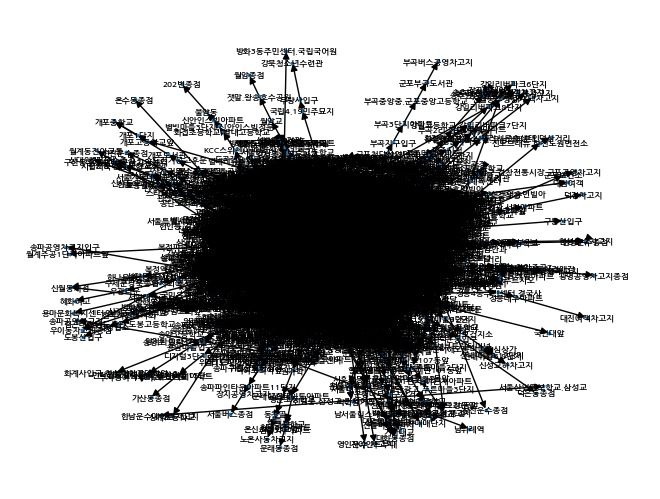

In [ ]:
pos = nx.spring_layout(graph, seed=234)

labels = nx.get_node_attributes(graph, 'name')
nx.draw(graph, pos, node_size=3, labels=labels, font_family='NanumGothic', font_size=6, font_weight='bold')

plt.axis('off')
plt.tight_layout()